In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from itertools import product

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)

WORKING_DIR = 'C:/term_project'
os.chdir(WORKING_DIR)
DATA_DIR = os.path.join(WORKING_DIR, 'data')
RESULT_DIR = os.path.join(WORKING_DIR, 'results')

print("Libraries imported and environment set.")

Libraries imported and environment set.


In [2]:
# HYPERPARAMETERS

TEST_SPLIT_RATIO = 0.2
LAG_WEEKS = [4, 8, 12]
ROLLING_WEEKS = [4, 8, 12]
PEARSON_PRUNE_THRESHOLD = 0.95
PATIENCE = 20

# LightGBM Parameter Grid
PARAM_GRID = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50],
    'max_depth': [-1, 10, 20],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [3]:
# LOAD DATA

train_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_train.csv'), index_col=[0, 1, 2])
train_labels = pd.read_csv(os.path.join(DATA_DIR, 'dengue_labels_train.csv'), index_col=[0, 1, 2])

# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

print("San Juan features:", sj_train_features.shape)
print("Iquitos features:", iq_train_features.shape)

# PREPROCESS DATA 

def preprocess_city_data(features, labels=None):
    """
    Merges features and labels, converts week_start_date to index,
    and handles missing values.
    """
    # 1. Merge features and labels if labels are provided
    if labels is not None:
        df = features.join(labels)
    else:
        df = features.copy()
    
    # 2. Reset index to move 'year' and 'weekofyear' from index to columns
    df.reset_index(inplace=True)
    
    # 3. Convert week_start_date to datetime
    df['week_start_date'] = pd.to_datetime(df['week_start_date'])
    
    # 4. Set week_start_date as index
    df.set_index('week_start_date', inplace=True)
    
    # 5. Drop 'city' column
    if 'city' in df.columns:
        df.drop(columns=['city'], inplace=True)
    
    # 6. Fill Missing Values (Interpolate is better for weather data)
    df = df.interpolate(method='time', limit_direction='both')
    df = df.ffill().bfill() # Fallback for edges
    
    # 7. Add Cyclical Features
    # 52.1775 weeks per average Gregorian year
    if 'weekofyear' in df.columns:
        df['week_sin'] = np.sin(2 * np.pi * df['weekofyear'] / 52.1775)
        df['week_cos'] = np.cos(2 * np.pi * df['weekofyear'] / 52.1775)
    
    return df

# Apply to San Juan and Iquitos
sj_train = preprocess_city_data(sj_train_features, sj_train_labels)
iq_train = preprocess_city_data(iq_train_features, iq_train_labels)

print("San Juan Preprocessed:", sj_train.shape)
print("Iquitos Preprocessed:", iq_train.shape)

San Juan features: (936, 21)
Iquitos features: (520, 21)
San Juan Preprocessed: (936, 25)
Iquitos Preprocessed: (520, 25)


In [4]:
# FEATURE ENGINEERING

def add_engineered_features(df, rolling_weeks=ROLLING_WEEKS, lag_weeks=LAG_WEEKS):
    """
    Adds rolling mean/std and lag features.
    """
    df_eng = df.copy()
    # Select numeric feature columns
    # MODIFIED: Include 'total_cases' so we can generate lags for it
    feature_cols = [c for c in df.columns]
    
    new_features = []
    for col in feature_cols:
        # Skip year/weekofyear for rolling stats if desired, but they are monotonic/cyclic so maybe skip
        if col in ['year', 'weekofyear']:
            continue
            
        # Rolling features
        for window in rolling_weeks:
            rolling = df_eng[col].rolling(window=window)
            
            if col == 'total_cases':
                # CRITICAL: Shift target rolling features by 1 to avoid leakage.
                # We want rolling mean of (t-1, t-2...), not including t.
                new_features.append(rolling.mean().shift(1).rename(f'{col}_mean_{window}'))
                new_features.append(rolling.std().shift(1).rename(f'{col}_std_{window}'))
            else:
                new_features.append(rolling.mean().rename(f'{col}_mean_{window}'))
                new_features.append(rolling.std().rename(f'{col}_std_{window}'))
            
        # Lag features
        for lag in lag_weeks:
            new_features.append(df_eng[col].shift(lag).rename(f'{col}_lag_{lag}'))
    
    if new_features:
        df_features = pd.concat(new_features, axis=1)
        df_eng = pd.concat([df_eng, df_features], axis=1)
        
    # Drop NaNs created by rolling/lags
    df_eng.dropna(inplace=True)
    return df_eng

def remove_collinear_features(df, threshold):
    """
    Removes features that are highly correlated with each other.
    Keeps the first feature and drops the subsequent highly correlated ones.
    """
    df_clean = df.copy()
    
    # Calculate correlation matrix
    # Only use feature columns (exclude target)
    if 'total_cases' in df_clean.columns:
        features = df_clean.drop(columns=['total_cases'])
    else:
        features = df_clean
        
    corr_matrix = features.corr().abs()
    
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Dropping {len(to_drop)} features due to collinearity > {threshold}")
    df_clean.drop(columns=to_drop, inplace=True)
    
    return df_clean, to_drop

print("Adding engineered features (rolling + lags)...")
sj_train_eng = add_engineered_features(sj_train)
iq_train_eng = add_engineered_features(iq_train)

print("Removing collinear features...")
sj_train_eng, sj_dropped = remove_collinear_features(sj_train_eng, PEARSON_PRUNE_THRESHOLD)
iq_train_eng, iq_dropped = remove_collinear_features(iq_train_eng, PEARSON_PRUNE_THRESHOLD)

# Store kept features for test set consistency
sj_features_kept = [c for c in sj_train_eng.columns if c != 'total_cases']
iq_features_kept = [c for c in iq_train_eng.columns if c != 'total_cases']

print("San Juan Engineered:", sj_train_eng.shape)
print("Iquitos Engineered:", iq_train_eng.shape)

Adding engineered features (rolling + lags)...
Removing collinear features...
Dropping 62 features due to collinearity > 0.95
Dropping 41 features due to collinearity > 0.95
San Juan Engineered: (924, 170)
Iquitos Engineered: (508, 191)


In [5]:
# SCALING AND DATA PREPARATION

def prepare_data(df, target_col='total_cases', scaler_X=None, scaler_y=None, is_train=True):
    # Separate features and target
    if target_col in df.columns:
        X = df.drop(columns=[target_col]).values
        y = df[[target_col]].values
        
        # LOG TRANSFORM: Stabilize variance
        if y is not None:
            y = np.log1p(y)
    else:
        X = df.values
        y = None
        
    # Scale X
    if is_train:
        scaler_X = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
    else:
        X_scaled = scaler_X.transform(X)
        
    # Scale y
    if y is not None:
        if is_train:
            scaler_y = StandardScaler()
            y_scaled = scaler_y.fit_transform(y)
        else:
            y_scaled = scaler_y.transform(y)
    else:
        y_scaled = None
        
    # Flatten y for LightGBM (it expects 1D array for y)
    if y_scaled is not None:
        y_scaled = y_scaled.ravel()
        
    return X_scaled, y_scaled, scaler_X, scaler_y

def split_and_prepare(df, split_ratio=0.8):
    split_idx = int(len(df) * split_ratio)
    train_df = df.iloc[:split_idx]
    val_df = df.iloc[split_idx:]
    
    # Prepare Train
    X_train, y_train, scaler_X, scaler_y = prepare_data(train_df, is_train=True)
    
    # Prepare Val
    # For LightGBM, we don't need to prepend history because features (lags) are already in the row.
    X_val, y_val, _, _ = prepare_data(val_df, scaler_X=scaler_X, scaler_y=scaler_y, is_train=False)
    
    return X_train, y_train, X_val, y_val, scaler_X, scaler_y, val_df

print("Preparing Data...")
train_ratio = 1.0 - TEST_SPLIT_RATIO
X_train_sj, y_train_sj, X_val_sj, y_val_sj, scaler_X_sj, scaler_y_sj, val_df_sj = split_and_prepare(sj_train_eng, split_ratio=train_ratio)
X_train_iq, y_train_iq, X_val_iq, y_val_iq, scaler_X_iq, scaler_y_iq, val_df_iq = split_and_prepare(iq_train_eng, split_ratio=train_ratio)

print("San Juan Train:", X_train_sj.shape, y_train_sj.shape)
print("San Juan Val:", X_val_sj.shape, y_val_sj.shape)
print("Iquitos Train:", X_train_iq.shape, y_train_iq.shape)
print("Iquitos Val:", X_val_iq.shape, y_val_iq.shape)

Preparing Data...
San Juan Train: (739, 169) (739,)
San Juan Val: (185, 169) (185,)
Iquitos Train: (406, 190) (406,)
Iquitos Val: (102, 190) (102,)


In [6]:
# HYPERPARAMETER TUNING WITH GRID SEARCH
from sklearn.model_selection import TimeSeriesSplit

def train_and_evaluate(X_train, y_train, X_val, y_val, params):
    model = LGBMRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        max_depth=params['max_depth'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[lgb.early_stopping(stopping_rounds=PATIENCE, verbose=False)]
    )
    
    # Best iteration is automatically used for prediction if early stopping is triggered
    preds = model.predict(X_val)
    val_loss = mean_absolute_error(y_val, preds)
    
    return val_loss, model

def evaluate_cv(df, params, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_index, val_index in tscv.split(df):
        train_df = df.iloc[train_index]
        val_df = df.iloc[val_index]
        
        # Prepare Data
        X_train, y_train, scaler_X, scaler_y = prepare_data(train_df, is_train=True)
        X_val, y_val, _, _ = prepare_data(val_df, scaler_X=scaler_X, scaler_y=scaler_y, is_train=False)
        
        val_loss, _ = train_and_evaluate(X_train, y_train, X_val, y_val, params)
        scores.append(val_loss)
        
    return np.mean(scores)

# Generate all combinations
keys, values = zip(*PARAM_GRID.items())
param_combinations = [dict(zip(keys, v)) for v in product(*values)]

print(f"Grid Search with {len(param_combinations)} combinations...")

def grid_search(df, city_name):
    best_score = float('inf')
    best_params = None
    
    print(f"\nStarting Grid Search (CV) for {city_name}...")
    
    for i, params in enumerate(param_combinations):
        print(f"[{i+1}/{len(param_combinations)}] Testing params: {params}", end='\r')
        try:
            avg_val_loss = evaluate_cv(df, params, n_splits=3)
            
            if avg_val_loss < best_score:
                best_score = avg_val_loss
                best_params = params
        except Exception as e:
            print(f"\nError with params {params}: {e}")
            continue
            
    print(f"\nBest {city_name} Params: {best_params}")
    print(f"Best {city_name} CV Score (MAE): {best_score:.4f}")
    
    print("Retraining best model on fixed split...")
    X_train, y_train, X_val, y_val, scaler_X, scaler_y, _ = split_and_prepare(
        df, 
        split_ratio=1.0-TEST_SPLIT_RATIO
    )
    _, best_model = train_and_evaluate(X_train, y_train, X_val, y_val, best_params)
    
    return best_model, best_params, (scaler_X, scaler_y), (X_val, y_val)

# Run Grid Search
model_sj, best_params_sj, best_scalers_sj, best_val_data_sj = grid_search(sj_train_eng, "San Juan")
scaler_X_sj, scaler_y_sj = best_scalers_sj
X_val_sj, y_val_sj = best_val_data_sj

model_iq, best_params_iq, best_scalers_iq, best_val_data_iq = grid_search(iq_train_eng, "Iquitos")
scaler_X_iq, scaler_y_iq = best_scalers_iq
X_val_iq, y_val_iq = best_val_data_iq

Grid Search with 144 combinations...

Starting Grid Search (CV) for San Juan...
[144/144] Testing params: {'n_estimators': 200, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 20, 'subsample': 1.0, 'colsample_bytree': 1.0}}
Best San Juan Params: {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1, 'subsample': 0.8, 'colsample_bytree': 1.0}
Best San Juan CV Score (MAE): 0.4470
Retraining best model on fixed split...

Starting Grid Search (CV) for Iquitos...
[144/144] Testing params: {'n_estimators': 200, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 20, 'subsample': 1.0, 'colsample_bytree': 1.0}}
Best Iquitos Params: {'n_estimators': 100, 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1, 'subsample': 0.8, 'colsample_bytree': 1.0}
Best Iquitos CV Score (MAE): 0.5240
Retraining best model on fixed split...


San Juan MAE: 10.1072
Iquitos MAE: 4.8133


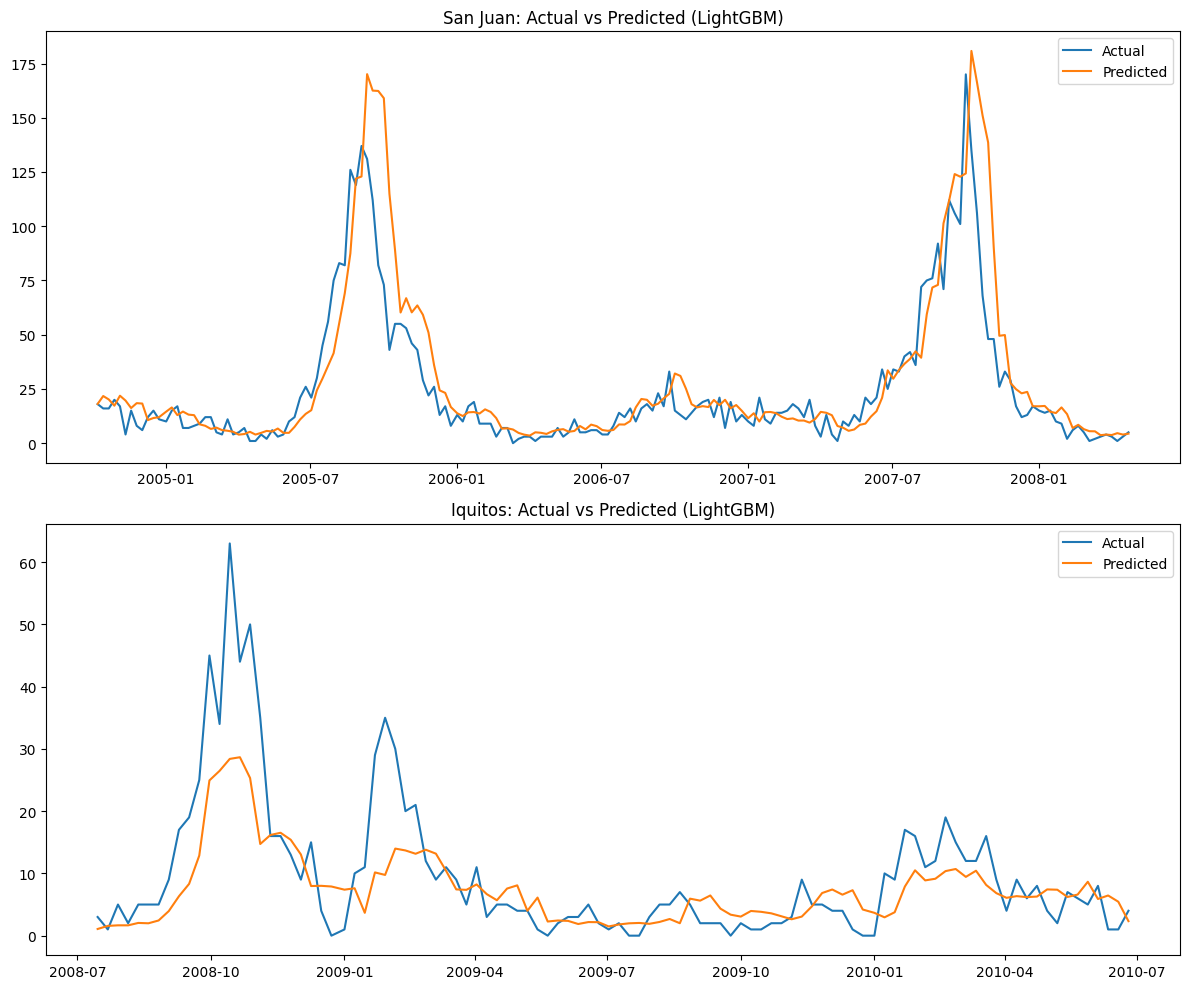

In [7]:
# EVALUATION

def evaluate_model(model, X_val, y_val_scaled, scaler_y, city_name):
    # Predict
    preds_scaled = model.predict(X_val)
    
    # Reshape for inverse transform
    preds_scaled = preds_scaled.reshape(-1, 1)
    y_val_scaled = y_val_scaled.reshape(-1, 1)
    
    # Inverse transform SCALING first
    preds_log = scaler_y.inverse_transform(preds_scaled)
    y_true_log = scaler_y.inverse_transform(y_val_scaled)
    
    # Inverse transform LOG (expm1)
    preds = np.expm1(preds_log)
    y_true = np.expm1(y_true_log)
    
    # Ensure non-negative
    preds = np.maximum(preds, 0)
    
    # Calculate MAE
    mae = mean_absolute_error(y_true, preds)
    print(f"{city_name} MAE: {mae:.4f}")
    
    return y_true, preds

# Evaluate San Juan
y_true_sj, preds_sj = evaluate_model(model_sj, X_val_sj, y_val_sj, scaler_y_sj, "San Juan")

# Evaluate Iquitos
y_true_iq, preds_iq = evaluate_model(model_iq, X_val_iq, y_val_iq, scaler_y_iq, "Iquitos")

# Plot
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# San Juan
ax[0].plot(val_df_sj.index, y_true_sj, label='Actual')
ax[0].plot(val_df_sj.index, preds_sj, label='Predicted')
ax[0].set_title('San Juan: Actual vs Predicted (LightGBM)')
ax[0].legend()

# Iquitos
ax[1].plot(val_df_iq.index, y_true_iq, label='Actual')
ax[1].plot(val_df_iq.index, preds_iq, label='Predicted')
ax[1].set_title('Iquitos: Actual vs Predicted (LightGBM)')
ax[1].legend()

plt.tight_layout()
plt.show()

In [8]:
# SUBMISSION

# 1. Load Test Data
test_features = pd.read_csv(os.path.join(DATA_DIR, 'dengue_features_test.csv'), index_col=[0, 1, 2])
sj_test_features = test_features.loc['sj']
iq_test_features = test_features.loc['iq']

# 2. Preprocess Test Data
sj_test = preprocess_city_data(sj_test_features)
iq_test = preprocess_city_data(iq_test_features)

# --- Retrain on FULL dataset for Submission ---
def retrain_full(df, params):
    X_train, y_train, scaler_X, scaler_y = prepare_data(df, is_train=True)
    
    model = LGBMRegressor(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        max_depth=params['max_depth'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    
    model.fit(X_train, y_train)
    return model, scaler_X, scaler_y

print("Retraining on full dataset for submission...")
model_sj_full, scaler_X_sj_full, scaler_y_sj_full = retrain_full(sj_train_eng, best_params_sj)
model_iq_full, scaler_X_iq_full, scaler_y_iq_full = retrain_full(iq_train_eng, best_params_iq)
# ---------------------------------------------------

def recursive_predict(model, scaler_X, scaler_y, train_df, test_df, features_kept, rolling_weeks, lag_weeks):
    # 1. Initialize history with training data
    history = train_df.copy()
    
    # 2. Prepare to store predictions
    predictions = []
    
    # 3. Calculate buffer size needed for lags (optimization)
    max_rolling = max(rolling_weeks) if rolling_weeks else 0
    max_lag = max(lag_weeks) if lag_weeks else 0
    buffer_size = max(max_rolling, max_lag) + 20
    
    print(f"Starting recursive prediction for {len(test_df)} weeks...")
    
    for i, (index, row) in enumerate(test_df.iterrows()):
        # A. Create a row with NaN target
        row_to_add = row.copy()
        # Ensure total_cases column exists
        row_to_add['total_cases'] = np.nan 
        
        # B. Append to history
        new_row_df = pd.DataFrame([row_to_add])
        history = pd.concat([history, new_row_df])
        
        # C. Generate features (only for the tail to save time)
        # We need enough history to compute the largest rolling window/lag
        history_tail = history.tail(buffer_size)
        history_eng = add_engineered_features(history_tail, rolling_weeks, lag_weeks)
        
        # D. Extract the feature vector for the current step (the last row)
        # Note: add_engineered_features drops NaNs, so if history is too short it might be empty.
        # But since we prepended full train set, it should be fine.
        current_features = history_eng.iloc[[-1]][features_kept]
        
        # E. Scale and Predict
        X_step = scaler_X.transform(current_features.values)
        pred_scaled = model.predict(X_step)
        
        # F. Inverse Transform
        pred_log = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1))
        pred_raw = np.expm1(pred_log)
        pred_val = max(0, pred_raw[0][0]) # Ensure non-negative
        
        # G. FILL THE PREDICTION BACK INTO HISTORY
        # This is the recursive step: this prediction becomes a lag for the next step
        history.iloc[-1, history.columns.get_loc('total_cases')] = pred_val
        
        predictions.append(int(pred_val))
        
        if i % 10 == 0:
            print(f"Step {i+1}/{len(test_df)}", end='\r')
            
    return np.array(predictions)

print("Generating Recursive Predictions...")
sj_preds_final = recursive_predict(model_sj_full, scaler_X_sj_full, scaler_y_sj_full, sj_train, sj_test, sj_features_kept, ROLLING_WEEKS, LAG_WEEKS)
iq_preds_final = recursive_predict(model_iq_full, scaler_X_iq_full, scaler_y_iq_full, iq_train, iq_test, iq_features_kept, ROLLING_WEEKS, LAG_WEEKS)

# Create Submission
submission = pd.read_csv(os.path.join(DATA_DIR, "submission_format.csv"), index_col=[0, 1, 2])
submission.loc['sj', 'total_cases'] = sj_preds_final
submission.loc['iq', 'total_cases'] = iq_preds_final

submission_path = os.path.join(WORKING_DIR, 'results', 'submission_lightgbm_2.csv')
submission.to_csv(submission_path)
print(f"Submission saved to {submission_path}")
submission.head()

Retraining on full dataset for submission...
Generating Recursive Predictions...
Starting recursive prediction for 260 weeks...
Starting recursive prediction for 156 weeks...
Submission saved to C:/term_project\results\submission_lightgbm_2.csv


total_cases
city year weekofyear             
sj   2008 18                    4
          19                    3
          20                    2
          21                    2
          22                    3